## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 192
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["1", "2"]
TEST_FRAGMENT = "3"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

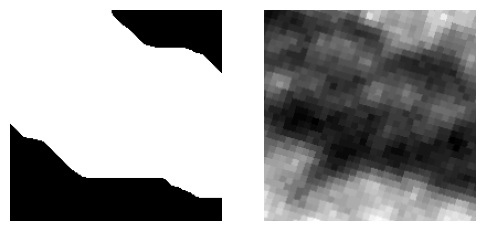

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-192 if x1 != 0 else 0, 192)
        y_offset = random.randint(-192 if y1 != 0 else 0, 192)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [13]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [14]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [15]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [16]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [17]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [18]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    # if epoch >= 10:
    #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 6.79GB  LR : 4.00E-06  Loss: 0.6970: 100%|██████████| 114/114 [00:48<00:00,  2.34it/s]                                                                                                                                                                       
Val Loss: 0.5993: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.103194
Threshold : 0.25	FBeta : 0.108176
Threshold : 0.30	FBeta : 0.126730
Threshold : 0.35	FBeta : 0.152706
Threshold : 0.40	FBeta : 0.168906
Threshold : 0.45	FBeta : 0.188303
Threshold : 0.50	FBeta : 0.213637
Threshold : 0.55	FBeta : 0.235485
Threshold : 0.60	FBeta : 0.234742
Threshold : 0.65	FBeta : 0.179445
Threshold : 0.70	FBeta : 0.069798
Threshold : 0.75	FBeta : 0.011696
Threshold : 0.80	FBeta : 0.000049



Epoch 2/50  Mem : 9.29GB  LR : 1.81E-05  Loss: 0.6441: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                       
Val Loss: 0.5282: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.160565
Threshold : 0.25	FBeta : 0.168521
Threshold : 0.30	FBeta : 0.178836
Threshold : 0.35	FBeta : 0.193597
Threshold : 0.40	FBeta : 0.209435
Threshold : 0.45	FBeta : 0.223104
Threshold : 0.50	FBeta : 0.239734
Threshold : 0.55	FBeta : 0.254330
Threshold : 0.60	FBeta : 0.270205
Threshold : 0.65	FBeta : 0.281970
Threshold : 0.70	FBeta : 0.273303
Threshold : 0.75	FBeta : 0.212307
Threshold : 0.80	FBeta : 0.080886



Epoch 3/50  Mem : 9.29GB  LR : 5.20E-05  Loss: 0.6064: 100%|██████████| 114/114 [00:49<00:00,  2.29it/s]                                                                                                                                                                       
Val Loss: 0.4686: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.179376
Threshold : 0.25	FBeta : 0.232243
Threshold : 0.30	FBeta : 0.281094
Threshold : 0.35	FBeta : 0.305077
Threshold : 0.40	FBeta : 0.312798
Threshold : 0.45	FBeta : 0.311722
Threshold : 0.50	FBeta : 0.290382
Threshold : 0.55	FBeta : 0.255008
Threshold : 0.60	FBeta : 0.217650
Threshold : 0.65	FBeta : 0.171572
Threshold : 0.70	FBeta : 0.114448
Threshold : 0.75	FBeta : 0.054134
Threshold : 0.80	FBeta : 0.019175



Epoch 4/50  Mem : 9.29GB  LR : 8.59E-05  Loss: 0.5885: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                       
Val Loss: 0.5221: 100%|██████████| 33/33 [00:08<00:00,  3.92it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.166256
Threshold : 0.25	FBeta : 0.177167
Threshold : 0.30	FBeta : 0.187196
Threshold : 0.35	FBeta : 0.197134
Threshold : 0.40	FBeta : 0.207953
Threshold : 0.45	FBeta : 0.223555
Threshold : 0.50	FBeta : 0.250347
Threshold : 0.55	FBeta : 0.280818
Threshold : 0.60	FBeta : 0.315686
Threshold : 0.65	FBeta : 0.350392
Threshold : 0.70	FBeta : 0.377561
Threshold : 0.75	FBeta : 0.374712
Threshold : 0.80	FBeta : 0.310154



Epoch 5/50  Mem : 9.29GB  LR : 1.00E-04  Loss: 0.5584: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                       
Val Loss: 0.4448: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.304512
Threshold : 0.25	FBeta : 0.366067
Threshold : 0.30	FBeta : 0.380232
Threshold : 0.35	FBeta : 0.387633
Threshold : 0.40	FBeta : 0.382110
Threshold : 0.45	FBeta : 0.371128
Threshold : 0.50	FBeta : 0.347345
Threshold : 0.55	FBeta : 0.316733
Threshold : 0.60	FBeta : 0.270892
Threshold : 0.65	FBeta : 0.219388
Threshold : 0.70	FBeta : 0.173509
Threshold : 0.75	FBeta : 0.123708
Threshold : 0.80	FBeta : 0.081607



Epoch 6/50  Mem : 9.29GB  LR : 9.99E-05  Loss: 0.5271: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                       
Val Loss: 0.4741: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.217052
Threshold : 0.25	FBeta : 0.231431
Threshold : 0.30	FBeta : 0.242969
Threshold : 0.35	FBeta : 0.253314
Threshold : 0.40	FBeta : 0.264396
Threshold : 0.45	FBeta : 0.279960
Threshold : 0.50	FBeta : 0.302246
Threshold : 0.55	FBeta : 0.322287
Threshold : 0.60	FBeta : 0.342318
Threshold : 0.65	FBeta : 0.360876
Threshold : 0.70	FBeta : 0.380946
Threshold : 0.75	FBeta : 0.401481
Threshold : 0.80	FBeta : 0.419657



Epoch 7/50  Mem : 9.29GB  LR : 9.95E-05  Loss: 0.5130: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                       
Val Loss: 0.5028: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.218470
Threshold : 0.25	FBeta : 0.229669
Threshold : 0.30	FBeta : 0.239501
Threshold : 0.35	FBeta : 0.248333
Threshold : 0.40	FBeta : 0.256915
Threshold : 0.45	FBeta : 0.266363
Threshold : 0.50	FBeta : 0.278059
Threshold : 0.55	FBeta : 0.292116
Threshold : 0.60	FBeta : 0.308412
Threshold : 0.65	FBeta : 0.326361
Threshold : 0.70	FBeta : 0.345342
Threshold : 0.75	FBeta : 0.364435
Threshold : 0.80	FBeta : 0.386716



Epoch 8/50  Mem : 9.29GB  LR : 9.89E-05  Loss: 0.4940: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                       
Val Loss: 0.4189: 100%|██████████| 33/33 [00:08<00:00,  3.93it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.292781
Threshold : 0.25	FBeta : 0.303384
Threshold : 0.30	FBeta : 0.313579
Threshold : 0.35	FBeta : 0.321886
Threshold : 0.40	FBeta : 0.330490
Threshold : 0.45	FBeta : 0.341025
Threshold : 0.50	FBeta : 0.354804
Threshold : 0.55	FBeta : 0.371823
Threshold : 0.60	FBeta : 0.389277
Threshold : 0.65	FBeta : 0.407056
Threshold : 0.70	FBeta : 0.421416
Threshold : 0.75	FBeta : 0.430437
Threshold : 0.80	FBeta : 0.434038



Epoch 9/50  Mem : 9.29GB  LR : 9.81E-05  Loss: 0.4845: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                       
Val Loss: 0.3871: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.354458
Threshold : 0.25	FBeta : 0.376255
Threshold : 0.30	FBeta : 0.394420
Threshold : 0.35	FBeta : 0.410389
Threshold : 0.40	FBeta : 0.425151
Threshold : 0.45	FBeta : 0.439548
Threshold : 0.50	FBeta : 0.451429
Threshold : 0.55	FBeta : 0.457168
Threshold : 0.60	FBeta : 0.461777
Threshold : 0.65	FBeta : 0.465956
Threshold : 0.70	FBeta : 0.464329
Threshold : 0.75	FBeta : 0.455963
Threshold : 0.80	FBeta : 0.441962



Epoch 10/50  Mem : 9.29GB  LR : 9.70E-05  Loss: 0.4661: 100%|██████████| 114/114 [00:48<00:00,  2.34it/s]                                                                                                                                                                      
Val Loss: 0.4811: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.243780
Threshold : 0.25	FBeta : 0.254663
Threshold : 0.30	FBeta : 0.264744
Threshold : 0.35	FBeta : 0.274645
Threshold : 0.40	FBeta : 0.284999
Threshold : 0.45	FBeta : 0.298019
Threshold : 0.50	FBeta : 0.312685
Threshold : 0.55	FBeta : 0.324677
Threshold : 0.60	FBeta : 0.337521
Threshold : 0.65	FBeta : 0.351009
Threshold : 0.70	FBeta : 0.365912
Threshold : 0.75	FBeta : 0.383326
Threshold : 0.80	FBeta : 0.402777



Epoch 11/50  Mem : 9.29GB  LR : 9.57E-05  Loss: 0.4628: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.4237: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.417789
Threshold : 0.25	FBeta : 0.425583
Threshold : 0.30	FBeta : 0.430361
Threshold : 0.35	FBeta : 0.431808
Threshold : 0.40	FBeta : 0.430791
Threshold : 0.45	FBeta : 0.424862
Threshold : 0.50	FBeta : 0.415139
Threshold : 0.55	FBeta : 0.403853
Threshold : 0.60	FBeta : 0.388719
Threshold : 0.65	FBeta : 0.367413
Threshold : 0.70	FBeta : 0.339681
Threshold : 0.75	FBeta : 0.302447
Threshold : 0.80	FBeta : 0.251465



Epoch 12/50  Mem : 9.29GB  LR : 9.41E-05  Loss: 0.4519: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3879: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.521312
Threshold : 0.25	FBeta : 0.529394
Threshold : 0.30	FBeta : 0.533224
Threshold : 0.35	FBeta : 0.533598
Threshold : 0.40	FBeta : 0.532023
Threshold : 0.45	FBeta : 0.528532
Threshold : 0.50	FBeta : 0.523539
Threshold : 0.55	FBeta : 0.513714
Threshold : 0.60	FBeta : 0.500555
Threshold : 0.65	FBeta : 0.476680
Threshold : 0.70	FBeta : 0.441249
Threshold : 0.75	FBeta : 0.398227
Threshold : 0.80	FBeta : 0.338322



Epoch 13/50  Mem : 9.29GB  LR : 9.24E-05  Loss: 0.4480: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3825: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.450516
Threshold : 0.25	FBeta : 0.464490
Threshold : 0.30	FBeta : 0.476993
Threshold : 0.35	FBeta : 0.485142
Threshold : 0.40	FBeta : 0.492108
Threshold : 0.45	FBeta : 0.497059
Threshold : 0.50	FBeta : 0.500671
Threshold : 0.55	FBeta : 0.504295
Threshold : 0.60	FBeta : 0.507883
Threshold : 0.65	FBeta : 0.508626
Threshold : 0.70	FBeta : 0.508927
Threshold : 0.75	FBeta : 0.507510
Threshold : 0.80	FBeta : 0.497577



Epoch 14/50  Mem : 9.29GB  LR : 9.05E-05  Loss: 0.4418: 100%|██████████| 114/114 [00:49<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.5359: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.238402
Threshold : 0.25	FBeta : 0.249094
Threshold : 0.30	FBeta : 0.257925
Threshold : 0.35	FBeta : 0.265323
Threshold : 0.40	FBeta : 0.272508
Threshold : 0.45	FBeta : 0.280236
Threshold : 0.50	FBeta : 0.288189
Threshold : 0.55	FBeta : 0.296657
Threshold : 0.60	FBeta : 0.305615
Threshold : 0.65	FBeta : 0.316370
Threshold : 0.70	FBeta : 0.329056
Threshold : 0.75	FBeta : 0.344198
Threshold : 0.80	FBeta : 0.362640



Epoch 15/50  Mem : 9.29GB  LR : 8.83E-05  Loss: 0.4349: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3695: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.484341
Threshold : 0.25	FBeta : 0.501336
Threshold : 0.30	FBeta : 0.514072
Threshold : 0.35	FBeta : 0.522644
Threshold : 0.40	FBeta : 0.527818
Threshold : 0.45	FBeta : 0.531423
Threshold : 0.50	FBeta : 0.533857
Threshold : 0.55	FBeta : 0.536453
Threshold : 0.60	FBeta : 0.535918
Threshold : 0.65	FBeta : 0.528587
Threshold : 0.70	FBeta : 0.518220
Threshold : 0.75	FBeta : 0.496199
Threshold : 0.80	FBeta : 0.459806



Epoch 16/50  Mem : 9.29GB  LR : 8.60E-05  Loss: 0.4351: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.4008: 100%|██████████| 33/33 [00:08<00:00,  3.93it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.283843
Threshold : 0.25	FBeta : 0.301597
Threshold : 0.30	FBeta : 0.317591
Threshold : 0.35	FBeta : 0.331726
Threshold : 0.40	FBeta : 0.344880
Threshold : 0.45	FBeta : 0.358140
Threshold : 0.50	FBeta : 0.371456
Threshold : 0.55	FBeta : 0.386883
Threshold : 0.60	FBeta : 0.405824
Threshold : 0.65	FBeta : 0.429026
Threshold : 0.70	FBeta : 0.457355
Threshold : 0.75	FBeta : 0.488501
Threshold : 0.80	FBeta : 0.518444



Epoch 17/50  Mem : 9.29GB  LR : 8.35E-05  Loss: 0.4231: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3609: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.386300
Threshold : 0.25	FBeta : 0.406418
Threshold : 0.30	FBeta : 0.423136
Threshold : 0.35	FBeta : 0.437304
Threshold : 0.40	FBeta : 0.449048
Threshold : 0.45	FBeta : 0.459994
Threshold : 0.50	FBeta : 0.470004
Threshold : 0.55	FBeta : 0.480257
Threshold : 0.60	FBeta : 0.491245
Threshold : 0.65	FBeta : 0.502266
Threshold : 0.70	FBeta : 0.514619
Threshold : 0.75	FBeta : 0.527665
Threshold : 0.80	FBeta : 0.541770



Epoch 18/50  Mem : 9.29GB  LR : 8.08E-05  Loss: 0.4120: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.4410: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276822
Threshold : 0.25	FBeta : 0.289359
Threshold : 0.30	FBeta : 0.300048
Threshold : 0.35	FBeta : 0.309302
Threshold : 0.40	FBeta : 0.317739
Threshold : 0.45	FBeta : 0.325865
Threshold : 0.50	FBeta : 0.334847
Threshold : 0.55	FBeta : 0.345575
Threshold : 0.60	FBeta : 0.358364
Threshold : 0.65	FBeta : 0.373748
Threshold : 0.70	FBeta : 0.391979
Threshold : 0.75	FBeta : 0.412994
Threshold : 0.80	FBeta : 0.437932



Epoch 19/50  Mem : 9.29GB  LR : 7.80E-05  Loss: 0.4271: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3680: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.370471
Threshold : 0.25	FBeta : 0.384575
Threshold : 0.30	FBeta : 0.396082
Threshold : 0.35	FBeta : 0.407150
Threshold : 0.40	FBeta : 0.416759
Threshold : 0.45	FBeta : 0.425798
Threshold : 0.50	FBeta : 0.435010
Threshold : 0.55	FBeta : 0.446174
Threshold : 0.60	FBeta : 0.457130
Threshold : 0.65	FBeta : 0.467591
Threshold : 0.70	FBeta : 0.478302
Threshold : 0.75	FBeta : 0.489508
Threshold : 0.80	FBeta : 0.500533



Epoch 20/50  Mem : 9.29GB  LR : 7.50E-05  Loss: 0.4054: 100%|██████████| 114/114 [00:48<00:00,  2.34it/s]                                                                                                                                                                      
Val Loss: 0.4129: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.283130
Threshold : 0.25	FBeta : 0.298643
Threshold : 0.30	FBeta : 0.312992
Threshold : 0.35	FBeta : 0.326652
Threshold : 0.40	FBeta : 0.338948
Threshold : 0.45	FBeta : 0.350007
Threshold : 0.50	FBeta : 0.361054
Threshold : 0.55	FBeta : 0.373188
Threshold : 0.60	FBeta : 0.387779
Threshold : 0.65	FBeta : 0.405271
Threshold : 0.70	FBeta : 0.426257
Threshold : 0.75	FBeta : 0.453388
Threshold : 0.80	FBeta : 0.486955



Epoch 21/50  Mem : 9.29GB  LR : 7.19E-05  Loss: 0.3988: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3484: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.431799
Threshold : 0.25	FBeta : 0.448961
Threshold : 0.30	FBeta : 0.466022
Threshold : 0.35	FBeta : 0.481134
Threshold : 0.40	FBeta : 0.492859
Threshold : 0.45	FBeta : 0.503691
Threshold : 0.50	FBeta : 0.514200
Threshold : 0.55	FBeta : 0.525232
Threshold : 0.60	FBeta : 0.536242
Threshold : 0.65	FBeta : 0.545272
Threshold : 0.70	FBeta : 0.553341
Threshold : 0.75	FBeta : 0.559634
Threshold : 0.80	FBeta : 0.557009



Epoch 22/50  Mem : 9.29GB  LR : 6.87E-05  Loss: 0.3944: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3907: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.316668
Threshold : 0.25	FBeta : 0.331311
Threshold : 0.30	FBeta : 0.344148
Threshold : 0.35	FBeta : 0.354740
Threshold : 0.40	FBeta : 0.364391
Threshold : 0.45	FBeta : 0.373977
Threshold : 0.50	FBeta : 0.384865
Threshold : 0.55	FBeta : 0.396895
Threshold : 0.60	FBeta : 0.412194
Threshold : 0.65	FBeta : 0.430876
Threshold : 0.70	FBeta : 0.451665
Threshold : 0.75	FBeta : 0.476053
Threshold : 0.80	FBeta : 0.503993



Epoch 23/50  Mem : 9.29GB  LR : 6.55E-05  Loss: 0.4025: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3744: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.352422
Threshold : 0.25	FBeta : 0.371812
Threshold : 0.30	FBeta : 0.387549
Threshold : 0.35	FBeta : 0.401340
Threshold : 0.40	FBeta : 0.413695
Threshold : 0.45	FBeta : 0.424832
Threshold : 0.50	FBeta : 0.435748
Threshold : 0.55	FBeta : 0.446793
Threshold : 0.60	FBeta : 0.458396
Threshold : 0.65	FBeta : 0.470729
Threshold : 0.70	FBeta : 0.485266
Threshold : 0.75	FBeta : 0.500293
Threshold : 0.80	FBeta : 0.516742



Epoch 24/50  Mem : 9.29GB  LR : 6.21E-05  Loss: 0.3834: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3730: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.592610
Threshold : 0.25	FBeta : 0.598966
Threshold : 0.30	FBeta : 0.599740
Threshold : 0.35	FBeta : 0.598235
Threshold : 0.40	FBeta : 0.595466
Threshold : 0.45	FBeta : 0.591892
Threshold : 0.50	FBeta : 0.585546
Threshold : 0.55	FBeta : 0.578980
Threshold : 0.60	FBeta : 0.570387
Threshold : 0.65	FBeta : 0.560187
Threshold : 0.70	FBeta : 0.548318
Threshold : 0.75	FBeta : 0.529690
Threshold : 0.80	FBeta : 0.496334



Epoch 25/50  Mem : 9.29GB  LR : 5.87E-05  Loss: 0.3926: 100%|██████████| 114/114 [00:49<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3414: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.474903
Threshold : 0.25	FBeta : 0.493732
Threshold : 0.30	FBeta : 0.508399
Threshold : 0.35	FBeta : 0.519394
Threshold : 0.40	FBeta : 0.526715
Threshold : 0.45	FBeta : 0.533099
Threshold : 0.50	FBeta : 0.539674
Threshold : 0.55	FBeta : 0.544840
Threshold : 0.60	FBeta : 0.549666
Threshold : 0.65	FBeta : 0.556170
Threshold : 0.70	FBeta : 0.562785
Threshold : 0.75	FBeta : 0.570415
Threshold : 0.80	FBeta : 0.577893



Epoch 26/50  Mem : 9.29GB  LR : 5.52E-05  Loss: 0.3764: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.4000: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.310266
Threshold : 0.25	FBeta : 0.329156
Threshold : 0.30	FBeta : 0.345715
Threshold : 0.35	FBeta : 0.359482
Threshold : 0.40	FBeta : 0.370493
Threshold : 0.45	FBeta : 0.379785
Threshold : 0.50	FBeta : 0.388312
Threshold : 0.55	FBeta : 0.397374
Threshold : 0.60	FBeta : 0.407835
Threshold : 0.65	FBeta : 0.420750
Threshold : 0.70	FBeta : 0.436262
Threshold : 0.75	FBeta : 0.455770
Threshold : 0.80	FBeta : 0.479722



Epoch 27/50  Mem : 9.29GB  LR : 5.17E-05  Loss: 0.3736: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.4806: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.257577
Threshold : 0.25	FBeta : 0.269161
Threshold : 0.30	FBeta : 0.279849
Threshold : 0.35	FBeta : 0.289387
Threshold : 0.40	FBeta : 0.297629
Threshold : 0.45	FBeta : 0.305277
Threshold : 0.50	FBeta : 0.313306
Threshold : 0.55	FBeta : 0.322070
Threshold : 0.60	FBeta : 0.332187
Threshold : 0.65	FBeta : 0.343924
Threshold : 0.70	FBeta : 0.358564
Threshold : 0.75	FBeta : 0.377369
Threshold : 0.80	FBeta : 0.402246



Epoch 28/50  Mem : 9.29GB  LR : 4.83E-05  Loss: 0.3742: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3469: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.464322
Threshold : 0.25	FBeta : 0.481242
Threshold : 0.30	FBeta : 0.494791
Threshold : 0.35	FBeta : 0.505423
Threshold : 0.40	FBeta : 0.515478
Threshold : 0.45	FBeta : 0.524553
Threshold : 0.50	FBeta : 0.532270
Threshold : 0.55	FBeta : 0.538793
Threshold : 0.60	FBeta : 0.544924
Threshold : 0.65	FBeta : 0.550116
Threshold : 0.70	FBeta : 0.551829
Threshold : 0.75	FBeta : 0.549198
Threshold : 0.80	FBeta : 0.536196



Epoch 29/50  Mem : 9.29GB  LR : 4.48E-05  Loss: 0.3774: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3557: 100%|██████████| 33/33 [00:08<00:00,  3.91it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.383097
Threshold : 0.25	FBeta : 0.403152
Threshold : 0.30	FBeta : 0.419281
Threshold : 0.35	FBeta : 0.432130
Threshold : 0.40	FBeta : 0.443150
Threshold : 0.45	FBeta : 0.453075
Threshold : 0.50	FBeta : 0.463557
Threshold : 0.55	FBeta : 0.475493
Threshold : 0.60	FBeta : 0.488377
Threshold : 0.65	FBeta : 0.501733
Threshold : 0.70	FBeta : 0.516256
Threshold : 0.75	FBeta : 0.532100
Threshold : 0.80	FBeta : 0.549482



Epoch 30/50  Mem : 9.29GB  LR : 4.13E-05  Loss: 0.3692: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3300: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.513067
Threshold : 0.25	FBeta : 0.531821
Threshold : 0.30	FBeta : 0.547312
Threshold : 0.35	FBeta : 0.558309
Threshold : 0.40	FBeta : 0.567663
Threshold : 0.45	FBeta : 0.575529
Threshold : 0.50	FBeta : 0.581998
Threshold : 0.55	FBeta : 0.587061
Threshold : 0.60	FBeta : 0.592583
Threshold : 0.65	FBeta : 0.597480
Threshold : 0.70	FBeta : 0.602672
Threshold : 0.75	FBeta : 0.607878
Threshold : 0.80	FBeta : 0.607790



Epoch 31/50  Mem : 9.29GB  LR : 3.79E-05  Loss: 0.3634: 100%|██████████| 114/114 [00:49<00:00,  2.29it/s]                                                                                                                                                                      
Val Loss: 0.3337: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.417709
Threshold : 0.25	FBeta : 0.444066
Threshold : 0.30	FBeta : 0.465252
Threshold : 0.35	FBeta : 0.484065
Threshold : 0.40	FBeta : 0.501127
Threshold : 0.45	FBeta : 0.515686
Threshold : 0.50	FBeta : 0.528582
Threshold : 0.55	FBeta : 0.540814
Threshold : 0.60	FBeta : 0.552429
Threshold : 0.65	FBeta : 0.564156
Threshold : 0.70	FBeta : 0.576329
Threshold : 0.75	FBeta : 0.591145
Threshold : 0.80	FBeta : 0.606398



Epoch 32/50  Mem : 9.29GB  LR : 3.45E-05  Loss: 0.3628: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3354: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.432835
Threshold : 0.25	FBeta : 0.454217
Threshold : 0.30	FBeta : 0.472009
Threshold : 0.35	FBeta : 0.487009
Threshold : 0.40	FBeta : 0.499964
Threshold : 0.45	FBeta : 0.511565
Threshold : 0.50	FBeta : 0.522263
Threshold : 0.55	FBeta : 0.533343
Threshold : 0.60	FBeta : 0.544875
Threshold : 0.65	FBeta : 0.556908
Threshold : 0.70	FBeta : 0.569376
Threshold : 0.75	FBeta : 0.582231
Threshold : 0.80	FBeta : 0.594372



Epoch 33/50  Mem : 9.29GB  LR : 3.13E-05  Loss: 0.3724: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3376: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.472989
Threshold : 0.25	FBeta : 0.493698
Threshold : 0.30	FBeta : 0.509331
Threshold : 0.35	FBeta : 0.521758
Threshold : 0.40	FBeta : 0.531906
Threshold : 0.45	FBeta : 0.540219
Threshold : 0.50	FBeta : 0.548923
Threshold : 0.55	FBeta : 0.556808
Threshold : 0.60	FBeta : 0.564245
Threshold : 0.65	FBeta : 0.573346
Threshold : 0.70	FBeta : 0.581477
Threshold : 0.75	FBeta : 0.589811
Threshold : 0.80	FBeta : 0.593550



Epoch 34/50  Mem : 9.29GB  LR : 2.81E-05  Loss: 0.3512: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3376: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.462602
Threshold : 0.25	FBeta : 0.478578
Threshold : 0.30	FBeta : 0.491284
Threshold : 0.35	FBeta : 0.502234
Threshold : 0.40	FBeta : 0.512025
Threshold : 0.45	FBeta : 0.519731
Threshold : 0.50	FBeta : 0.527095
Threshold : 0.55	FBeta : 0.534618
Threshold : 0.60	FBeta : 0.541918
Threshold : 0.65	FBeta : 0.548981
Threshold : 0.70	FBeta : 0.556651
Threshold : 0.75	FBeta : 0.564580
Threshold : 0.80	FBeta : 0.572997



Epoch 35/50  Mem : 9.29GB  LR : 2.50E-05  Loss: 0.3529: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3252: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.497050
Threshold : 0.25	FBeta : 0.516720
Threshold : 0.30	FBeta : 0.531138
Threshold : 0.35	FBeta : 0.542716
Threshold : 0.40	FBeta : 0.550897
Threshold : 0.45	FBeta : 0.558216
Threshold : 0.50	FBeta : 0.564910
Threshold : 0.55	FBeta : 0.571678
Threshold : 0.60	FBeta : 0.579209
Threshold : 0.65	FBeta : 0.587431
Threshold : 0.70	FBeta : 0.596828
Threshold : 0.75	FBeta : 0.607247
Threshold : 0.80	FBeta : 0.619407



Epoch 36/50  Mem : 9.29GB  LR : 2.20E-05  Loss: 0.3567: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3512: 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.393118
Threshold : 0.25	FBeta : 0.411990
Threshold : 0.30	FBeta : 0.427183
Threshold : 0.35	FBeta : 0.440118
Threshold : 0.40	FBeta : 0.451414
Threshold : 0.45	FBeta : 0.461679
Threshold : 0.50	FBeta : 0.471072
Threshold : 0.55	FBeta : 0.480451
Threshold : 0.60	FBeta : 0.490406
Threshold : 0.65	FBeta : 0.502230
Threshold : 0.70	FBeta : 0.516468
Threshold : 0.75	FBeta : 0.534222
Threshold : 0.80	FBeta : 0.554421



Epoch 37/50  Mem : 9.29GB  LR : 1.92E-05  Loss: 0.3512: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3368: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.481308
Threshold : 0.25	FBeta : 0.500120
Threshold : 0.30	FBeta : 0.514395
Threshold : 0.35	FBeta : 0.525271
Threshold : 0.40	FBeta : 0.534976
Threshold : 0.45	FBeta : 0.542943
Threshold : 0.50	FBeta : 0.550231
Threshold : 0.55	FBeta : 0.557597
Threshold : 0.60	FBeta : 0.565022
Threshold : 0.65	FBeta : 0.571642
Threshold : 0.70	FBeta : 0.577833
Threshold : 0.75	FBeta : 0.585623
Threshold : 0.80	FBeta : 0.593361



Epoch 38/50  Mem : 9.29GB  LR : 1.65E-05  Loss: 0.3416: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3394: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.446641
Threshold : 0.25	FBeta : 0.464663
Threshold : 0.30	FBeta : 0.479478
Threshold : 0.35	FBeta : 0.491724
Threshold : 0.40	FBeta : 0.501934
Threshold : 0.45	FBeta : 0.510590
Threshold : 0.50	FBeta : 0.519139
Threshold : 0.55	FBeta : 0.527618
Threshold : 0.60	FBeta : 0.536526
Threshold : 0.65	FBeta : 0.546301
Threshold : 0.70	FBeta : 0.556502
Threshold : 0.75	FBeta : 0.567636
Threshold : 0.80	FBeta : 0.579920



Epoch 39/50  Mem : 9.29GB  LR : 1.40E-05  Loss: 0.3456: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3346: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.455279
Threshold : 0.25	FBeta : 0.477416
Threshold : 0.30	FBeta : 0.494813
Threshold : 0.35	FBeta : 0.508331
Threshold : 0.40	FBeta : 0.520144
Threshold : 0.45	FBeta : 0.530735
Threshold : 0.50	FBeta : 0.540808
Threshold : 0.55	FBeta : 0.550576
Threshold : 0.60	FBeta : 0.559281
Threshold : 0.65	FBeta : 0.566980
Threshold : 0.70	FBeta : 0.575580
Threshold : 0.75	FBeta : 0.585556
Threshold : 0.80	FBeta : 0.595372



Epoch 40/50  Mem : 9.29GB  LR : 1.17E-05  Loss: 0.3391: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3338: 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.464605
Threshold : 0.25	FBeta : 0.482770
Threshold : 0.30	FBeta : 0.497198
Threshold : 0.35	FBeta : 0.508658
Threshold : 0.40	FBeta : 0.518402
Threshold : 0.45	FBeta : 0.527038
Threshold : 0.50	FBeta : 0.535581
Threshold : 0.55	FBeta : 0.543597
Threshold : 0.60	FBeta : 0.551696
Threshold : 0.65	FBeta : 0.559098
Threshold : 0.70	FBeta : 0.567713
Threshold : 0.75	FBeta : 0.575826
Threshold : 0.80	FBeta : 0.584522



Epoch 41/50  Mem : 9.29GB  LR : 9.55E-06  Loss: 0.3406: 100%|██████████| 114/114 [00:48<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3339: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.455472
Threshold : 0.25	FBeta : 0.474909
Threshold : 0.30	FBeta : 0.489482
Threshold : 0.35	FBeta : 0.501198
Threshold : 0.40	FBeta : 0.511499
Threshold : 0.45	FBeta : 0.520914
Threshold : 0.50	FBeta : 0.529591
Threshold : 0.55	FBeta : 0.538109
Threshold : 0.60	FBeta : 0.546278
Threshold : 0.65	FBeta : 0.554716
Threshold : 0.70	FBeta : 0.563889
Threshold : 0.75	FBeta : 0.573012
Threshold : 0.80	FBeta : 0.582689



Epoch 42/50  Mem : 9.29GB  LR : 7.60E-06  Loss: 0.3315: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3287: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.502724
Threshold : 0.25	FBeta : 0.520130
Threshold : 0.30	FBeta : 0.534654
Threshold : 0.35	FBeta : 0.545066
Threshold : 0.40	FBeta : 0.553896
Threshold : 0.45	FBeta : 0.561744
Threshold : 0.50	FBeta : 0.569122
Threshold : 0.55	FBeta : 0.576162
Threshold : 0.60	FBeta : 0.582869
Threshold : 0.65	FBeta : 0.589370
Threshold : 0.70	FBeta : 0.596173
Threshold : 0.75	FBeta : 0.601926
Threshold : 0.80	FBeta : 0.607482



Epoch 43/50  Mem : 9.29GB  LR : 5.85E-06  Loss: 0.3416: 100%|██████████| 114/114 [00:48<00:00,  2.34it/s]                                                                                                                                                                      
Val Loss: 0.3322: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.457571
Threshold : 0.25	FBeta : 0.478861
Threshold : 0.30	FBeta : 0.496311
Threshold : 0.35	FBeta : 0.509291
Threshold : 0.40	FBeta : 0.518790
Threshold : 0.45	FBeta : 0.527633
Threshold : 0.50	FBeta : 0.536145
Threshold : 0.55	FBeta : 0.545389
Threshold : 0.60	FBeta : 0.554504
Threshold : 0.65	FBeta : 0.563220
Threshold : 0.70	FBeta : 0.572454
Threshold : 0.75	FBeta : 0.581844
Threshold : 0.80	FBeta : 0.590861



Epoch 44/50  Mem : 9.29GB  LR : 4.32E-06  Loss: 0.3223: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3307: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.461946
Threshold : 0.25	FBeta : 0.482201
Threshold : 0.30	FBeta : 0.497667
Threshold : 0.35	FBeta : 0.510175
Threshold : 0.40	FBeta : 0.520643
Threshold : 0.45	FBeta : 0.529640
Threshold : 0.50	FBeta : 0.537745
Threshold : 0.55	FBeta : 0.546840
Threshold : 0.60	FBeta : 0.556349
Threshold : 0.65	FBeta : 0.566288
Threshold : 0.70	FBeta : 0.575185
Threshold : 0.75	FBeta : 0.583882
Threshold : 0.80	FBeta : 0.593751



Epoch 45/50  Mem : 9.29GB  LR : 3.02E-06  Loss: 0.3334: 100%|██████████| 114/114 [00:49<00:00,  2.30it/s]                                                                                                                                                                      
Val Loss: 0.3268: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.502539
Threshold : 0.25	FBeta : 0.520117
Threshold : 0.30	FBeta : 0.533669
Threshold : 0.35	FBeta : 0.543956
Threshold : 0.40	FBeta : 0.552265
Threshold : 0.45	FBeta : 0.560427
Threshold : 0.50	FBeta : 0.568120
Threshold : 0.55	FBeta : 0.574927
Threshold : 0.60	FBeta : 0.581110
Threshold : 0.65	FBeta : 0.586413
Threshold : 0.70	FBeta : 0.592962
Threshold : 0.75	FBeta : 0.600356
Threshold : 0.80	FBeta : 0.605577



Epoch 46/50  Mem : 9.29GB  LR : 1.94E-06  Loss: 0.3301: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3303: 100%|██████████| 33/33 [00:08<00:00,  3.93it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.476964
Threshold : 0.25	FBeta : 0.496285
Threshold : 0.30	FBeta : 0.510715
Threshold : 0.35	FBeta : 0.522379
Threshold : 0.40	FBeta : 0.532110
Threshold : 0.45	FBeta : 0.541625
Threshold : 0.50	FBeta : 0.550344
Threshold : 0.55	FBeta : 0.558294
Threshold : 0.60	FBeta : 0.566287
Threshold : 0.65	FBeta : 0.573553
Threshold : 0.70	FBeta : 0.581860
Threshold : 0.75	FBeta : 0.589565
Threshold : 0.80	FBeta : 0.598474



Epoch 47/50  Mem : 9.29GB  LR : 1.09E-06  Loss: 0.3257: 100%|██████████| 114/114 [00:49<00:00,  2.33it/s]                                                                                                                                                                      
Val Loss: 0.3290: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.481355
Threshold : 0.25	FBeta : 0.500298
Threshold : 0.30	FBeta : 0.514285
Threshold : 0.35	FBeta : 0.524510
Threshold : 0.40	FBeta : 0.533613
Threshold : 0.45	FBeta : 0.542616
Threshold : 0.50	FBeta : 0.550921
Threshold : 0.55	FBeta : 0.558077
Threshold : 0.60	FBeta : 0.564881
Threshold : 0.65	FBeta : 0.571721
Threshold : 0.70	FBeta : 0.580214
Threshold : 0.75	FBeta : 0.588395
Threshold : 0.80	FBeta : 0.595772



Epoch 48/50  Mem : 9.29GB  LR : 4.87E-07  Loss: 0.3269: 100%|██████████| 114/114 [00:49<00:00,  2.31it/s]                                                                                                                                                                      
Val Loss: 0.3277: 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.504650
Threshold : 0.25	FBeta : 0.521740
Threshold : 0.30	FBeta : 0.535188
Threshold : 0.35	FBeta : 0.545762
Threshold : 0.40	FBeta : 0.553616
Threshold : 0.45	FBeta : 0.559805
Threshold : 0.50	FBeta : 0.566120
Threshold : 0.55	FBeta : 0.572626
Threshold : 0.60	FBeta : 0.579027
Threshold : 0.65	FBeta : 0.585234
Threshold : 0.70	FBeta : 0.591339
Threshold : 0.75	FBeta : 0.597553
Threshold : 0.80	FBeta : 0.603851



Epoch 49/50  Mem : 9.29GB  LR : 1.22E-07  Loss: 0.3251: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3335: 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.468245
Threshold : 0.25	FBeta : 0.486446
Threshold : 0.30	FBeta : 0.501060
Threshold : 0.35	FBeta : 0.512416
Threshold : 0.40	FBeta : 0.521362
Threshold : 0.45	FBeta : 0.530030
Threshold : 0.50	FBeta : 0.538728
Threshold : 0.55	FBeta : 0.546837
Threshold : 0.60	FBeta : 0.554686
Threshold : 0.65	FBeta : 0.562276
Threshold : 0.70	FBeta : 0.571132
Threshold : 0.75	FBeta : 0.580652
Threshold : 0.80	FBeta : 0.589653



Epoch 50/50  Mem : 9.29GB  LR : 4.00E-10  Loss: 0.3281: 100%|██████████| 114/114 [00:49<00:00,  2.32it/s]                                                                                                                                                                      
Val Loss: 0.3292: 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.497982
Threshold : 0.25	FBeta : 0.515425
Threshold : 0.30	FBeta : 0.527417
Threshold : 0.35	FBeta : 0.537585
Threshold : 0.40	FBeta : 0.546279
Threshold : 0.45	FBeta : 0.553440
Threshold : 0.50	FBeta : 0.560676
Threshold : 0.55	FBeta : 0.567866
Threshold : 0.60	FBeta : 0.574330
Threshold : 0.65	FBeta : 0.580197
Threshold : 0.70	FBeta : 0.587098
Threshold : 0.75	FBeta : 0.592423
Threshold : 0.80	FBeta : 0.598161



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
